## Data exploration notebook

The goal of this notebook is to grasp how our dataset looks like. It will serve as data pre-processing as we will try to generate a better dataset so that our model can learn.

In [99]:
import pandas as pd
from matplotlib import pyplot as plt

In [100]:
# Read the dataset
train_data = pd.read_csv('../data/supply_chain_train.csv', index_col='train_idx')
test_data = pd.read_csv('../data/supply_chain_test.csv', index_col='test_idx')

In [101]:
print('Train data shape: ', train_data.shape)
print('Test data shape: ', test_data.shape)

Train data shape:  (8101, 21)
Test data shape:  (2026, 20)


In [102]:
train_data.head()

,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag
train_idx,,,,,,,,,,,,,,,,,,,,,
0,713071383,54,F,1,Unknown,Single,Unknown,Blue,36,1,...,3,3723.0,1728,1995.0,0.595,8554,99,0.678,0.464,1
1,714246333,58,F,4,High School,Married,Unknown,Blue,48,1,...,3,5396.0,1803,3593.0,0.493,2107,39,0.393,0.334,0
2,718206783,45,F,4,Unknown,Single,Less than $40K,Gold,36,6,...,3,15987.0,1648,14339.0,0.732,1436,36,1.250,0.103,1
3,721096983,34,F,2,Graduate,Single,Less than $40K,Blue,36,4,...,4,3625.0,2517,1108.0,1.158,2616,46,1.300,0.694,1
4,720028683,49,F,2,High School,Married,$40K - $60K,Blue,39,5,...,4,2720.0,1926,794.0,0.602,3806,61,0.794,0.708,1


### 1. Test and train datasets data distribution analysis

Check if the test and train datasests share the same data distributions in all variables.
Discard columns with uncorresponding distributions.

In [103]:
def get_comparison_chart(column:str, col_type:str=None, train_df=train_data, test_df=test_data, train_color='blue', test_color='orange'):
    """
    Returns a comparison chart with two superposed plots in the same figure, one for train and one for test.
    The chart will be a histogram if the column is numeric and continuous, and a difference bar plot if the column is categorical.

    Parameters:
        column (str): The column to be compared.
        col_type (str): The type of the column. If None, the type will be inferred from the column dtype.
        train_df (pd.DataFrame): The train dataset.
        test_df (pd.DataFrame): The test dataset.
        train_color (str): The color to be used for the train dataset.
        test_color (str): The color to be used for the test dataset.
    """
    assert column in train_df.columns and column in test_df.columns, f'{column} is not a valid cloumn in both train and test datasets.'

    fig, ax = plt.subplots()

    if col_type == 'categorical' or train_df[column].dtype == 'object':  
        # Categorical column: show the difference of the normalized distribution in a bar plot
        diff = train_df[column].value_counts(normalize=True) - test_df[column].value_counts(normalize=True)
        diff.plot(kind='bar', ax=ax, title=f'Train - Test distribution | {column}', color='black', legend=False)

        # Add the percentage to the bars: above the bar for positive values, below for negative values
        for p in ax.patches:
            ax.annotate(
                f'{abs(p.get_height()*100):.2f}%', 
                (p.get_x()+p.get_width()/2, p.get_height()*1.1), 
                ha='center', 
                va='bottom' if p.get_height() > 0 else 'top'
            )

        # Set y axis label and ticks with percentage
        ax.set_ylabel('Percentage')
        ax.set_yticks([i/100 for i in range(-10, 11, 2)])
        ax.set_yticklabels([f'{abs(i)}%' for i in range(-10, 11, 2)])

        ax.set_xlabel(column)

        # Add a horizontal line at 0
        ax.axhline(y=0, color='black', linestyle='--')

        # Add background color separating positive and negative values
        ax.axhspan(-0.1, 0, facecolor=test_color, alpha=0.1)
        ax.axhspan(0, 0.1, facecolor=train_color, alpha=0.1)

        # Add background color legend (train and test)
        ax.text(0.5, 0.9, 'train', ha='center', va='bottom', transform=ax.transAxes, color='black', fontsize=10)
        ax.text(0.5, 0.05, 'test', ha='center', va='bottom', transform=ax.transAxes, color='black', fontsize=10)

        # Add grid
        ax.grid(axis='y', linestyle='--')

    else: 
        # Numeric column: show the difference of the normalized distribution in a histogram with color
        train_df[column].hist(ax=ax, bins=20, density=True, color=train_color, alpha=0.5, label='train')
        test_df[column].hist(ax=ax, bins=20, density=True, color=test_color, alpha=0.5, label='test')

        # Add axis labels
        ax.set_xlabel(column)
        ax.set_ylabel('Percentage')

        # Add '%' to y axis ticks
        ax.set_yticklabels([f'{round(i, 2)}%' for i in ax.get_yticks()*100])

        ax.set_title(f'{column} distributions')
        ax.legend()
 
    return fig, ax

In [104]:
# Define the columns to plot and their type
columns_to_plot = train_data.columns[2:-1]
columns_type = {col: 'categorical' if train_data[col].dtype == 'object' else 'numeric' for col in columns_to_plot}
for col in {'Dependent_count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Total_Relationship_Count'}:
    columns_type[col] = 'categorical'
    
print(f'Columns to plot: {columns_to_plot}')
print(f'Columns type: {columns_type}')

Columns to plot: Index(['Gender', 'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')
Columns type: {'Gender': 'categorical', 'Dependent_count': 'categorical', 'Education_Level': 'categorical', 'Marital_Status': 'categorical', 'Income_Category': 'categorical', 'Card_Category': 'categorical', 'Months_on_book': 'numeric', 'Total_Relationship_Count': 'categorical', 'Months_Inactive_12_mon': 'categorical', 'Contacts_Count_12_mon': 'categorical', 'Credit_Limit': 'numeric', 'Total_Revolving_Bal': 'numeric', 'Avg_Open_To_Buy': 'numeric', 'Total_Amt_Chng_Q4_Q1': 'numeric', 'Total_Trans_Amt': 'numeric', 'Total_Trans_Ct': 'numeric', 'Total_

/tmp/ipykernel_9139/3962920236.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{round(i, 2)}%' for i in ax.get_yticks()*100])
/tmp/ipykernel_9139/3962920236.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{round(i, 2)}%' for i in ax.get_yticks()*100])


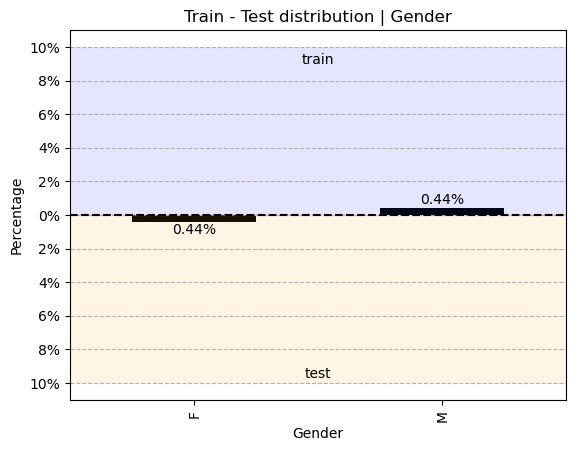

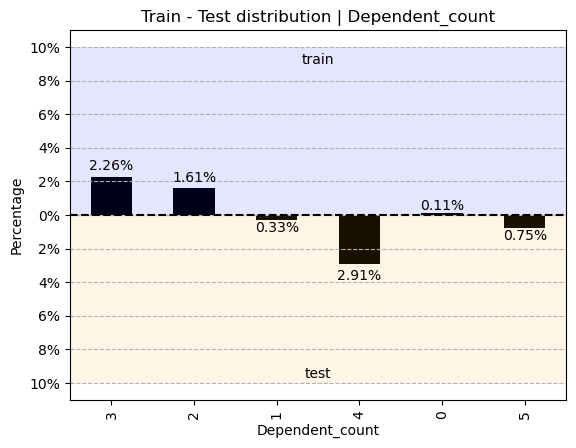

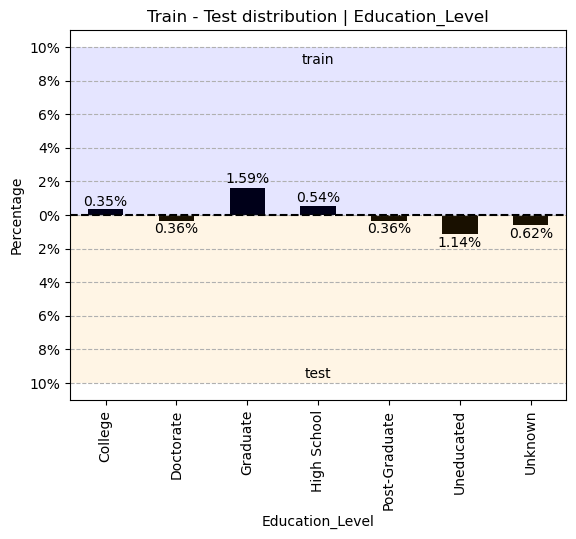

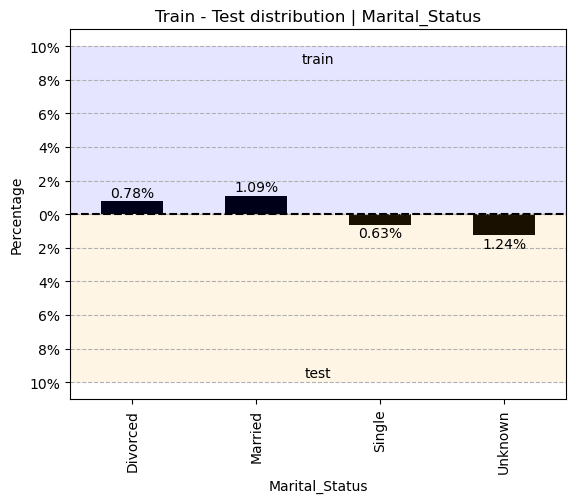

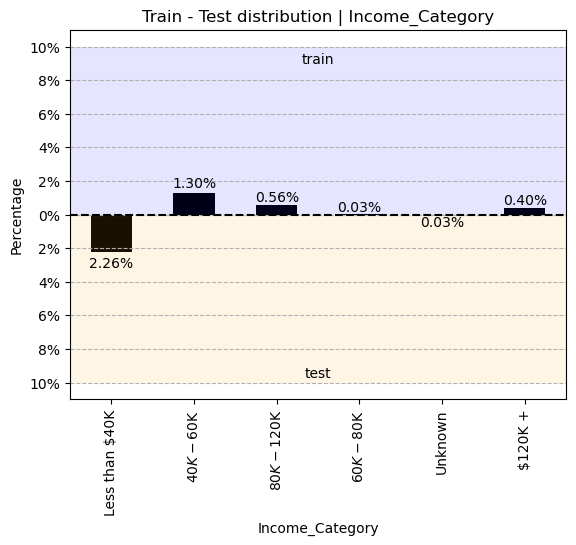

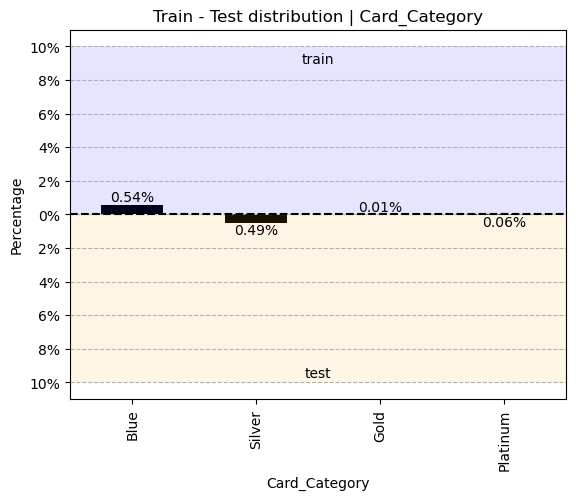

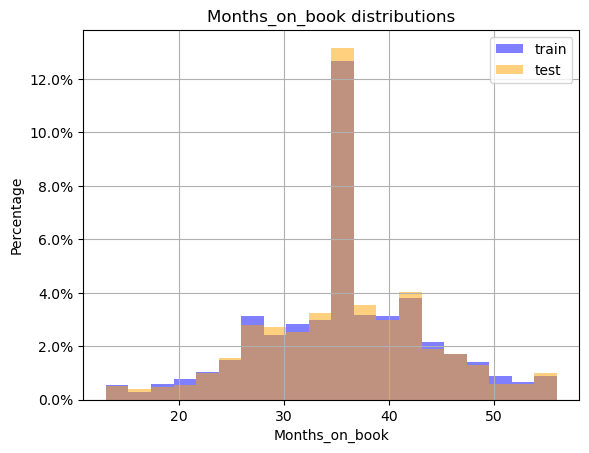

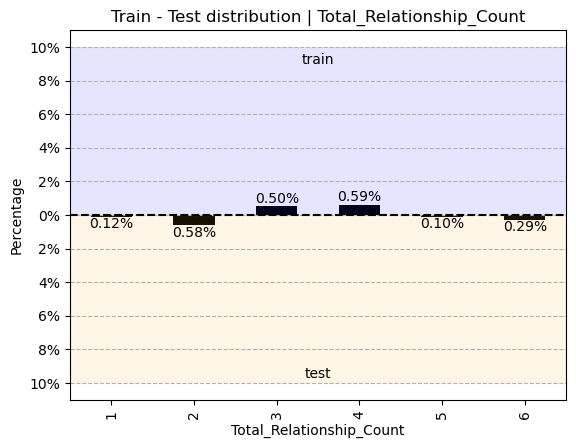

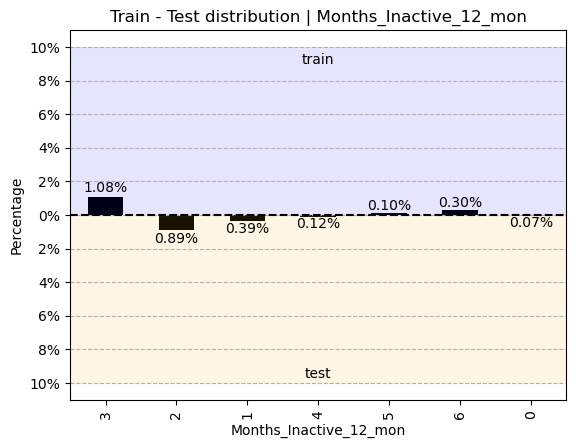

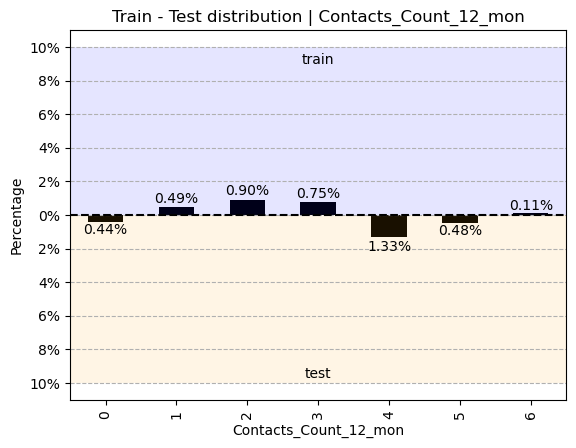

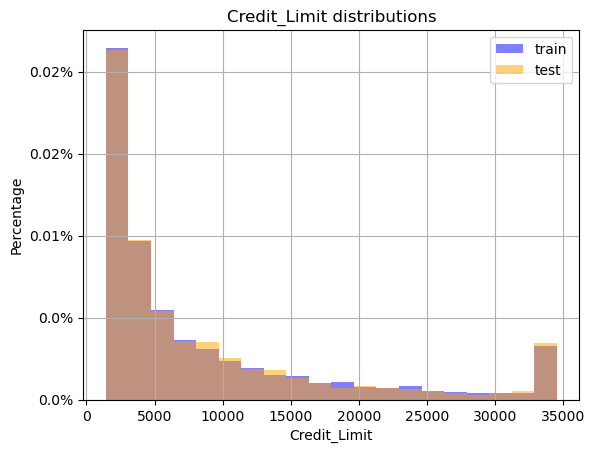

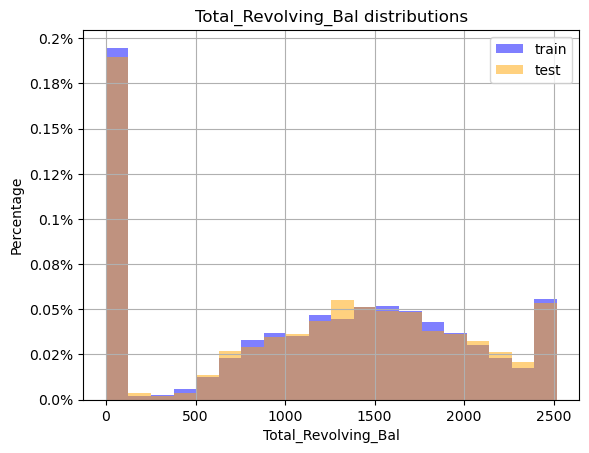

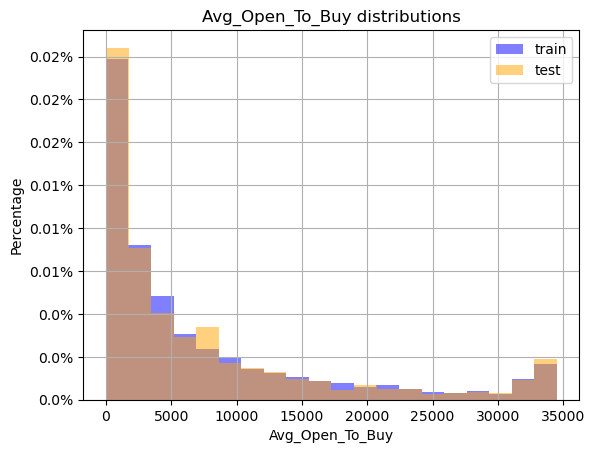

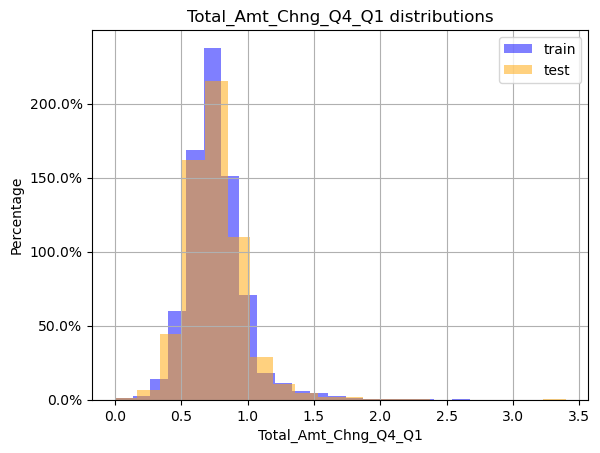

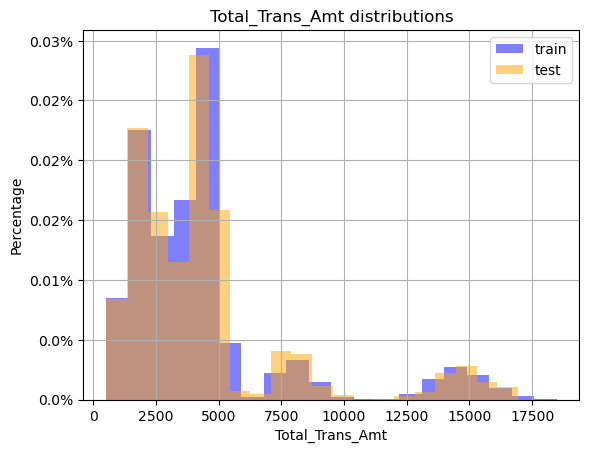

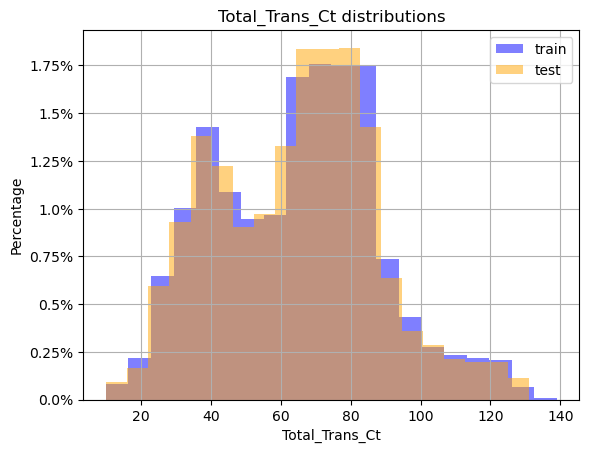

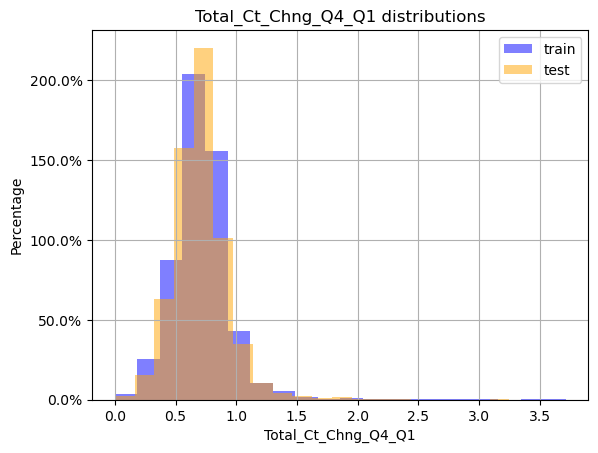

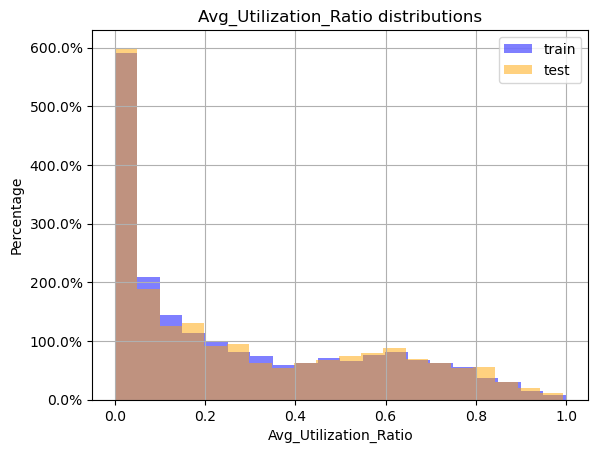

In [105]:
# Plot the comparison charts
for col in columns_to_plot:
    fig, ax = get_comparison_chart(col, columns_type[col])
    fig.show()

All the variables have very similar distributions. We will keep them all.

### 2. Get data correlations and relationship with target variable
Check if some data columns are not relevant for the classification task.

/tmp/ipykernel_9139/2735150434.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train_data.corr()


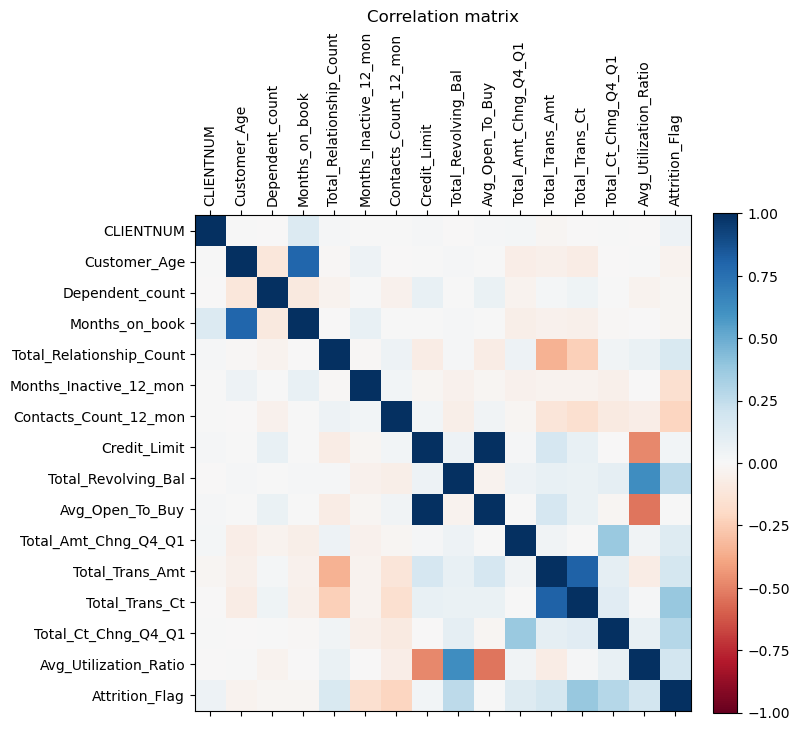

In [106]:
# Create a correlation matrix
corr_matrix = train_data.corr()

# Plot the correlation matrix
fig, ax = plt.subplots(figsize=(7, 7))
ax.matshow(corr_matrix, cmap='RdBu', vmin=-1, vmax=1)

# Set the ticks and labels
ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, rotation=90)
ax.set_yticks(range(len(corr_matrix.columns)))
ax.set_yticklabels(corr_matrix.columns)

ax.set_title('Correlation matrix')

fig.colorbar(ax.images[0], ax=ax, fraction=0.046, pad=0.04)

fig.show()

It looks like the higher the number of contacts that the client has had with the back in the last year (`Contacts_Count_12_mon`), the higher the probability of leaving the bank... Makes sense, as is always anoying to have multiple contacts. The number of months that the client has been inactive (`Months_Inactive_12_mon`) also has an impact on the probability of attriting from the bank.

On the other hand, the more transactions the client does (`Total_Trans_Ct`, `Total_Trans_Amt`), the more likely it is that he is happy with the bank services. The same happens with `Total_Revolving_Bal` and `Avg_Utilization_Ratio`.

Some variables have no significant correlation with the target. We will drop the columns with correlation lower than 0.05.

In [107]:
# Drop the columns with abs(correlation) < 0.05
columns_to_drop = [col for col in corr_matrix.columns if abs(corr_matrix[col]['Attrition_Flag']) < 0.05]
print(f'Columns to drop: {columns_to_drop}')

train_data.drop(columns_to_drop, axis=1, inplace=True)
test_data.drop(columns_to_drop, axis=1, inplace=True)

# Save the cleaned datasets
train_data.to_csv('../data/supply_chain_train_cleaned.csv', index=False)
test_data.to_csv('../data/supply_chain_test_cleaned.csv', index=False)

Columns to drop: ['CLIENTNUM', 'Customer_Age', 'Dependent_count', 'Months_on_book', 'Credit_Limit', 'Avg_Open_To_Buy']


We lost some data quality and variance, but we now have a more balanced dataset. We will train a model with both datasets, and see which one performs better.

### 3. Check for class imbalances
The number of Attrited Customers and Existing Customer in the training dataset should be similar. Otherwise, if no action is taken, the model will have a preference for the class with more examples.

In [108]:
print(f'Number of Attrition_Flag 0: {train_data.Attrition_Flag.value_counts()[0]} ({train_data.Attrition_Flag.value_counts()[0]/len(train_data)*100:.2f}%)')
print(f'Number of Attrition_Flag 1: {train_data.Attrition_Flag.value_counts()[1]} ({train_data.Attrition_Flag.value_counts()[1]/len(train_data)*100:.2f}%)')
print(f'Number of rows: {len(train_data)}')

Number of Attrition_Flag 0: 1300 (16.05%)
Number of Attrition_Flag 1: 6801 (83.95%)
Number of rows: 8101


The classes are highly imbalanced! We can deal with this using two main methods: cost-sensitive learning or sampling.
- In sampling, we can undersample from the majority class (might underfit), or re-sample from the minority class (might overfit). We can do both using the SMOTE algorithm.
- With cost-sensitive learning, we adress the problem via the loss function, but we are competing for the F1 score.

We will address the problem using sampling strategies. Before using SMOTE, we will check how the data looks like via a PCA. Maybe there is a better way to do sampling than using a general algorithm.

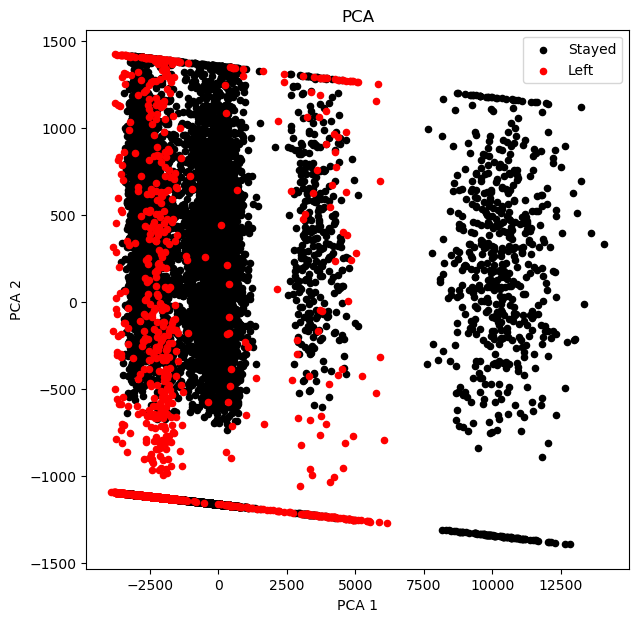

In [125]:
from sklearn.decomposition import PCA

# One-hot encode the categorical columns
pca_dataset = pd.get_dummies(train_data, columns=train_data.columns[train_data.dtypes == 'object'])

# Create the PCA object and transform the dataset
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pca_dataset)

# Create a dataframe with the PCA results. 
pca_df = pd.DataFrame(pca_result, columns=['PCA 1', 'PCA 2'])

# Add pca_dataset to pca_df
pca_df = pd.concat([pca_df, pca_dataset], axis=1)

# pca_df['Attrition_Flag'] = train_data['Attrition_Flag']
# pca_df['original_index'] = train_data.index


# Plot the PCA results: in red the customers that left, in black the customers that stayed
fig, ax = plt.subplots(figsize=(7, 7))
pca_df[pca_df['Attrition_Flag'] == 1].plot.scatter(x='PCA 1', y='PCA 2', ax=ax, color='black', label='Stayed')
pca_df[pca_df['Attrition_Flag'] == 0].plot.scatter(x='PCA 1', y='PCA 2', ax=ax, color='red', label='Left')

# Add axis labels
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')

# Add a legend
ax.legend()

# Add a title
ax.set_title('PCA')

fig.show()


In [126]:
pca_dataset

,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag,...,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
train_idx,,,,,,,,,,,,,,,,,,,,,
0,1,3,3,1728,0.595,8554,99,0.678,0.464,1,...,0,0,0,0,0,1,1,0,0,0
1,1,4,3,1803,0.493,2107,39,0.393,0.334,0,...,0,0,0,0,0,1,1,0,0,0
2,6,1,3,1648,0.732,1436,36,1.250,0.103,1,...,0,0,0,0,1,0,0,1,0,0
3,4,3,4,2517,1.158,2616,46,1.300,0.694,1,...,0,0,0,0,1,0,1,0,0,0
4,5,3,4,1926,0.602,3806,61,0.794,0.708,1,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8096,3,2,5,2517,0.809,2104,44,0.833,0.608,0,...,0,1,0,0,0,0,1,0,0,0
8097,4,3,6,0,0.551,2269,42,0.312,0.000,0,...,0,0,0,0,0,1,1,0,0,0
8098,3,1,2,1547,0.804,4678,74,1.000,0.669,1,...,0,0,0,0,1,0,1,0,0,0


It looks like we have 3-4 clusters! Let's try to fins them.

/home/usuaris/veu/gerard.calvo.bartra/miniconda3/envs/nuwe/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of customers in each cluster:
Attrition_Flag       0       1
Cluster                       
0                163.0   372.0
1                  NaN   605.0
2               1055.0  2143.0
3                 82.0  3681.0

Percentage of customers that left in each cluster:
Attrition_Flag         0         1
Cluster                           
0               0.304673  0.695327
1                    NaN  1.000000
2               0.329894  0.670106
3               0.021791  0.978209


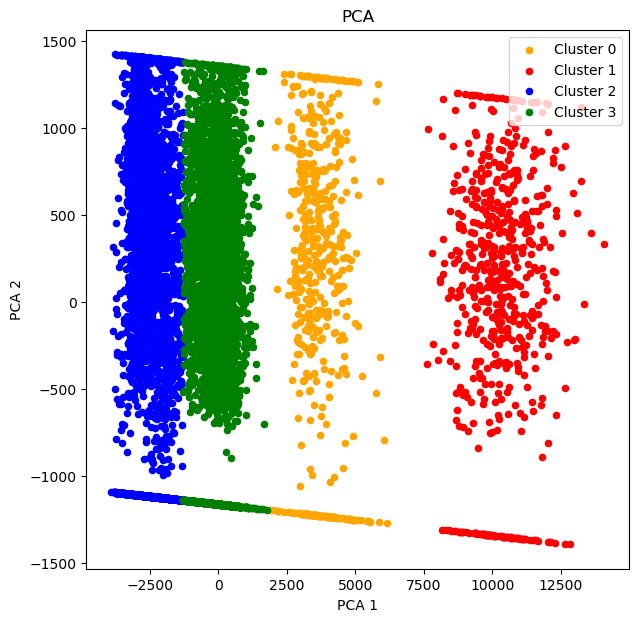

In [127]:
# Cluster the PCA results in 4 clusters, using a seed
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=20)
pca_df['Cluster'] = kmeans.fit_predict(pca_dataset)
pca_df['Cluster'] = pca_df['Cluster'].astype('category')

# Plot the PCA with the clusters in different colors
fig, ax = plt.subplots(figsize=(7, 7))
pca_df[pca_df['Cluster'] == 0].plot.scatter(x='PCA 1', y='PCA 2', ax=ax, color='orange', label='Cluster 0')
pca_df[pca_df['Cluster'] == 1].plot.scatter(x='PCA 1', y='PCA 2', ax=ax, color='red', label='Cluster 1')
pca_df[pca_df['Cluster'] == 2].plot.scatter(x='PCA 1', y='PCA 2', ax=ax, color='blue', label='Cluster 2')
pca_df[pca_df['Cluster'] == 3].plot.scatter(x='PCA 1', y='PCA 2', ax=ax, color='green', label='Cluster 3')

# Add plot information
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.legend()
ax.set_title('PCA')

fig.show()

# Print cluster information
print('Number of customers in each cluster:')  # Add the percentage of customers that left in each cluster
print(pca_df.groupby('Cluster')['Attrition_Flag'].value_counts().unstack())
print()
print('Percentage of customers that left in each cluster:')
print(pca_df.groupby('Cluster')['Attrition_Flag'].value_counts(normalize=True).unstack())


We found them!
Notice how Clusters 1 and 3 have a very low (or null) percentage of leaving customers. This means that with only a few examples on those clusters the model will be able to predict the correct label. This allows us to do undersmapling of data points on those regions for the most common class, which will lead to a more balanced dataset. Let's do this:

Number of customers in each cluster:
Attrition_Flag       0       1
Cluster                       
0                163.0   372.0
1                  NaN    12.0
2               1055.0  2143.0
3                 82.0   100.0

Percentage of customers that left in each cluster:
Attrition_Flag         0         1
Cluster                           
0               0.304673  0.695327
1                    NaN  1.000000
2               0.329894  0.670106
3               0.450549  0.549451


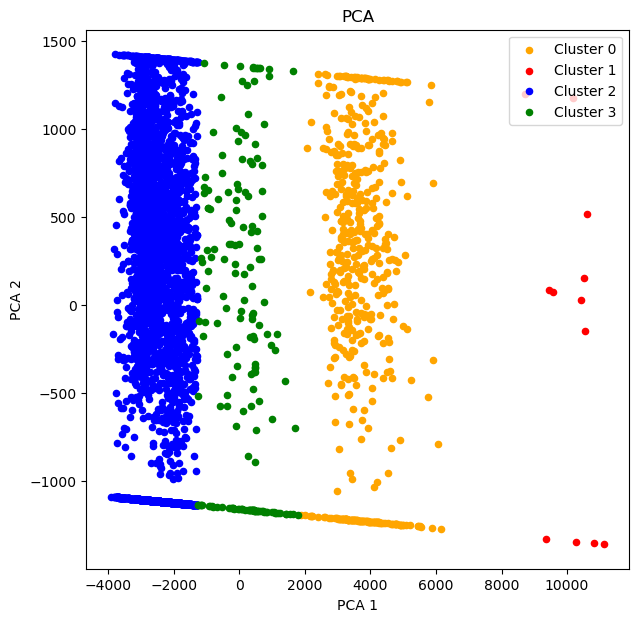

In [128]:
# Undersample the Attrition_Flag 1 class to balance the dataset

resampled_df  = pca_df.copy()

# On the cluster 1, we can get rid of 95% of the customers that left
resampled_df = resampled_df.drop(
    resampled_df[
        (resampled_df['Cluster'] == 1) &
        (resampled_df['Attrition_Flag'] == 1)
    ].sample(frac=0.98).index
)

# On cluster 3, we want to have nearly the same number of customers that left and that stayed
percentage_of_rows_to_keep = (
    len(resampled_df[(resampled_df['Cluster'] == 3) & (resampled_df['Attrition_Flag'] == 0)]) /
    len(resampled_df[(resampled_df['Cluster'] == 3) & (resampled_df['Attrition_Flag'] == 1)])
)+0.005
resampled_df = resampled_df.drop(
    resampled_df[
        (resampled_df['Cluster'] == 3) &
        (resampled_df['Attrition_Flag'] == 1)
    ].sample(frac=1-percentage_of_rows_to_keep).index
)

# Plot the PCA with the clusters in different colors
fig, ax = plt.subplots(figsize=(7, 7))
resampled_df[resampled_df['Cluster'] == 0].plot.scatter(x='PCA 1', y='PCA 2', ax=ax, color='orange', label='Cluster 0')
resampled_df[resampled_df['Cluster'] == 1].plot.scatter(x='PCA 1', y='PCA 2', ax=ax, color='red', label='Cluster 1')
resampled_df[resampled_df['Cluster'] == 2].plot.scatter(x='PCA 1', y='PCA 2', ax=ax, color='blue', label='Cluster 2')
resampled_df[resampled_df['Cluster'] == 3].plot.scatter(x='PCA 1', y='PCA 2', ax=ax, color='green', label='Cluster 3')

# Add plot information
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.legend()
ax.set_title('PCA')

fig.show()

# print the number of customers that left and that stayed in each cluster
print('Number of customers in each cluster:')
print(resampled_df.groupby('Cluster')['Attrition_Flag'].value_counts().unstack())
print()
print('Percentage of customers that left in each cluster:')
print(resampled_df.groupby('Cluster')['Attrition_Flag'].value_counts(normalize=True).unstack())


In [129]:
print(f'Number of Attrition_Flag 0: {resampled_df.Attrition_Flag.value_counts()[0]} ({resampled_df.Attrition_Flag.value_counts()[0]/len(resampled_df)*100:.2f}%)')
print(f'Number of Attrition_Flag 1: {resampled_df.Attrition_Flag.value_counts()[1]} ({resampled_df.Attrition_Flag.value_counts()[1]/len(resampled_df)*100:.2f}%)')
print(f'Number of rows: {len(resampled_df)}')

Number of Attrition_Flag 0: 1300 (33.10%)
Number of Attrition_Flag 1: 2627 (66.90%)
Number of rows: 3927


So far, we have grown the percentage of Attrition_Flag 0 from 16% to 33%, and without loosing any important information within the data! 
But we still have to thrive for that ~50%. Now, we can use the SMOTE algorithm to upsample the Attrition_Flag 0 data on clusters 0 and 2, as well as perform some downsampling on Attrition_Flag 1.

In [130]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Balance cluster 2
smote = SMOTE(sampling_strategy={0: 1550}, random_state=42)  # Oversample the Attrition_Flag 0 class
undersample = RandomUnderSampler(sampling_strategy={1: 1600}, random_state=42)  # Undersample the Attrition_Flag 1 class 
pipeline = Pipeline([('smote', smote), ('undersample', undersample)])

# Apply the pipeline to the dataset, only on the cluster 2
X = resampled_df[resampled_df['Cluster'] == 2].drop(['Attrition_Flag', 'Cluster'], axis=1)
y = resampled_df[resampled_df['Cluster'] == 2]['Attrition_Flag']
X_resampled, y_resampled = pipeline.fit_resample(X, y)

# Merge x and y into a dataframe, with the cluster 2
resampled_c2_df = pd.concat([X_resampled, y_resampled], axis=1)
resampled_c2_df['Cluster'] = 2

In [131]:
# Balance the cluster 0
smote = SMOTE(sampling_strategy={0: 250}, random_state=42)
undersample = RandomUnderSampler(sampling_strategy={1: 300}, random_state=42)
pipeline = Pipeline([('smote', smote), ('undersample', undersample)])

X = resampled_df[resampled_df['Cluster'] == 0].drop(['Attrition_Flag', 'Cluster'], axis=1)
y = resampled_df[resampled_df['Cluster'] == 0]['Attrition_Flag']
X_resampled, y_resampled = pipeline.fit_resample(X, y)

resampled_c0_df = pd.concat([X_resampled, y_resampled], axis=1)
resampled_c0_df['Cluster'] = 0

# Merge resampled_c0_df and resampled_c2_df with the rest of the clusters
resampled_v2_df = pd.concat([resampled_df[resampled_df['Cluster'] != 0], resampled_c0_df])
resampled_v2_df = pd.concat([resampled_v2_df[resampled_v2_df['Cluster'] != 2], resampled_c2_df])

# Print the number of customers that left and that stayed in each cluster
print('Number of customers in each cluster:')
print(resampled_v2_df.groupby('Cluster')['Attrition_Flag'].value_counts().unstack())
print()
print('Percentage of customers that left in each cluster:')
print(resampled_v2_df.groupby('Cluster')['Attrition_Flag'].value_counts(normalize=True).unstack())

Number of customers in each cluster:
Attrition_Flag       0       1
Cluster                       
0                250.0   300.0
1                  NaN    12.0
2               1550.0  1600.0
3                 82.0   100.0

Percentage of customers that left in each cluster:
Attrition_Flag         0         1
Cluster                           
0               0.454545  0.545455
1                    NaN  1.000000
2               0.492063  0.507937
3               0.450549  0.549451


We now have a nearly balanced dataset!
Let's see how the new PCA looks like:

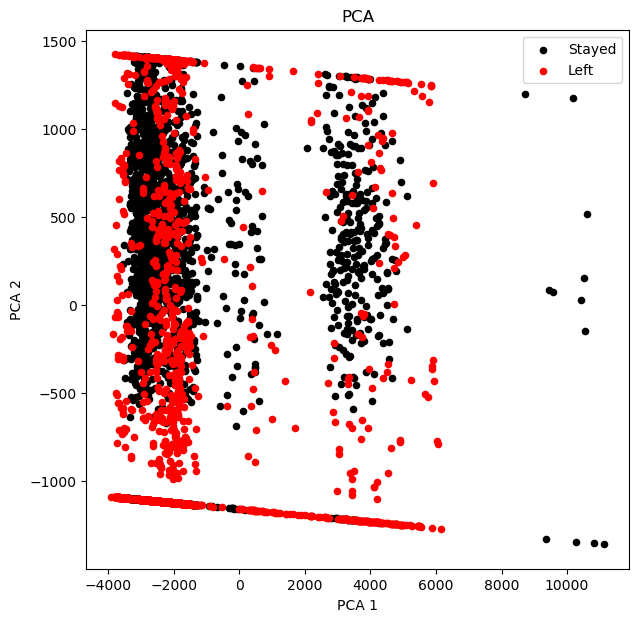

In [132]:
# Plot the PCA results with the new dataset
fig, ax = plt.subplots(figsize=(7, 7))

# In red the customers that left, in black the customers that stayed
resampled_v2_df[resampled_v2_df['Attrition_Flag'] == 1].plot.scatter(x='PCA 1', y='PCA 2', ax=ax, color='black', label='Stayed')
resampled_v2_df[resampled_v2_df['Attrition_Flag'] == 0].plot.scatter(x='PCA 1', y='PCA 2', ax=ax, color='red', label='Left')

# Add plot information
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.legend()
ax.set_title('PCA')

fig.show()

For now, we will forget about those two strange lines that appear at the top and bottom of the PCA plot. Those could appear because the lack of variability in the two principal components of the PCA.

Let's do some final touches to the new balanced dataset and save it.

In [139]:
# Remove the PCA and cluster columns
resampled_v2_df = resampled_v2_df.drop(['PCA 1', 'PCA 2', 'Cluster'], axis=1)

# Move the Attrition_Flag column to the end
cols = list(resampled_v2_df.columns.values)
cols.pop(cols.index('Attrition_Flag'))
resampled_v2_df = resampled_v2_df[cols+['Attrition_Flag']]

# Shuffle the dataset
resampled_v2_df = resampled_v2_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save the balanced dataset
resampled_v2_df.to_csv('../data/supply_chain_train_balanced.csv', index=False)

resampled_v2_df.head()

,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_F,...,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver,Attrition_Flag
0,6,3,2,1843,0.62500,2614,79,0.646000,0.562000,1,...,0,0,0,1,0,1,0,0,0,1
1,3,2,4,2321,0.49100,1734,38,0.583000,0.322000,0,...,0,1,0,0,0,1,0,0,0,1
2,4,3,4,922,0.65500,1518,39,0.625000,0.046000,0,...,0,1,0,0,0,1,0,0,0,1
3,4,2,3,217,0.49842,1892,48,0.720956,0.009074,0,...,0,0,0,0,0,1,0,0,0,0
4,3,2,3,0,0.83600,8376,64,0.684000,0.000000,0,...,0,1,0,0,0,1,0,0,0,0


### Conclusions

In this notebook we generated two new datasets that will be used to train different models:
- The first one, `supply_chain_train_cleaned,csv`, removed some columns that had no correlation with our target variable.
- The second one, `supply_chain_train_balanced.csv`, built on top of the first one, tackled the problem of data imbalance; we did smart undersampling of the majoriry class of our target variable, as well as creating plausible synthetic data, to achive a balanced dataset. Besides, in this dataset the categorical variables have been one-hot encoded.

We will do some benchmarking to see how the diferent models perform depending on the training dataset used.

Note: in a real life situation, the data processing pipeline would be transfered into a .py file (not in a notebook) for automatization. However, given that we won't have more data, this apporach suffices.